In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ==== CONFIG ====
csv_path = "sbc_counter_result.csv"

n_past = 24                   # số bước thời gian dùng làm input
target_counters = [1, 2, 3]   # các counter_id cần DỰ ĐOÁN (n_counter)

# ==== LOAD & PIVOT ====
df = pd.read_csv(csv_path)

# bỏ cột không dùng
df = df.drop(columns=['id', 'counter_option'])

# chuẩn hóa thời gian
df['trigger_time'] = pd.to_datetime(df['trigger_time'], unit='s')
df = df.sort_values('trigger_time')

# === pivot TẤT CẢ counter làm feature ===
# index = time, columns = (node_id, counter_id), value = counter_value
df_pivot = df.pivot_table(
    index='trigger_time',
    columns=['node_id', 'counter_id'],
    values='counter_value'
)

df_pivot = df_pivot.sort_index(axis=1)   # sắp xếp cột theo (node_id, counter_id)

print("df_pivot shape:", df_pivot.shape)     # (n_time, n_nodes * n_all_counters)
print("Một vài cột:", df_pivot.columns[:10])
df_pivot.head()

df_pivot shape: (26209, 120)
Một vài cột: MultiIndex([(1,  1),
            (1,  2),
            (1,  3),
            (1,  4),
            (1,  5),
            (1,  6),
            (1,  7),
            (1,  8),
            (1,  9),
            (1, 10)],
           names=['node_id', 'counter_id'])


node_id                    1                                               \
counter_id                1        2        3        4        5        6    
trigger_time                                                                
2025-09-07 18:39:27  22695.0  20238.0  20681.0  19287.0  22703.0  18683.0   
2025-09-07 18:44:27  21120.0  19911.0  21249.0  21861.0  18355.0  20104.0   
2025-09-07 18:49:27  19024.0  20255.0  19361.0  21907.0  18896.0  19823.0   
2025-09-07 18:54:27  19199.0  23258.0  20103.0  19764.0  18378.0  19695.0   
2025-09-07 18:59:27  20564.0  22984.0  17187.0  19524.0  21141.0  20346.0   

node_id                                                  ...        6  \
counter_id                7        8        9        10  ...       11   
trigger_time                                             ...            
2025-09-07 18:39:27  19338.0  19689.0  17477.0  18901.0  ...  23816.0   
2025-09-07 18:44:27  22204.0  20710.0  19171.0  21094.0  ...  20085.0   
2025-09-07 18:49:27  19579.0  18229.0  21886.0  19680.0  ...  20821.0   
2025-09-07 18:54:27  18769.0  19945.0  20138.0  18877.0  ...  17981.0   
2025-09-07 18:59:27  18875.0  20374.0  20394.0  17472.0  ...  19279.0   

node_id                                                                    \
counter_id                12       13       14       15       16       17   
trigger_time                                                                
2025-09-07 18:39:27  18616.0  19922.0  20057.0  18213.0  18327.0  17304.0   
2025-09-07 18:44:27  18478.0  21396.0  21944.0  20388.0  18512.0  20991.0   
2025-09-07 18:49:27  19749.0  17640.0  22354.0  21744.0  16455.0  18865.0   
2025-09-07 18:54:27  19731.0  18713.0  19907.0  21435.0  18740.0  21203.0   
2025-09-07 18:59:27  19909.0  21264.0  20723.0  19466.0  23496.0  24569.0   

node_id                                         
counter_id                18       19       20  
trigger_time                                    
2025-09-07 18:39:27  19542.0  21080.0  22515.0  
2025-09-07 18:44:27  19283.0  18880.0  18020.0  
2025-09-07 18:49:27  19036.0  20220.0  17023.0  
2025-09-07 18:54:27  20388.0  21997.0  20412.0  
2025-09-07 18:59:27  19481.0  19262.0  20204.0  

[5 rows x 120 columns]

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_pivot.values)

n_time, n_features_all = data_scaled.shape
node_ids = df_pivot.columns.get_level_values(0).unique()
all_counters = df_pivot.columns.get_level_values(1).unique()

n_nodes = len(node_ids)
n_all_counters = len(all_counters)

print("n_time:", n_time)
print("n_features_all:", n_features_all)
print("n_nodes:", n_nodes, "n_all_counters:", n_all_counters)

n_time: 26209
n_features_all: 120
n_nodes: 6 n_all_counters: 20


In [4]:
# Lấy MultiIndex columns
cols = df_pivot.columns  # MultiIndex (node_id, counter_id)

# Tìm index các cột có counter_id thuộc target_counters
target_col_indices = [
    i for i, (nid, cid) in enumerate(zip(cols.get_level_values(0), cols.get_level_values(1)))
    if cid in target_counters
]

print("Số cột target:", len(target_col_indices))
# n_target_features = n_nodes * n_target_counters
n_target_counters = len(target_counters)
assert len(target_col_indices) == n_nodes * n_target_counters

Số cột target: 18


In [5]:
def create_xy_all_features_target_subset(
    data_scaled,
    n_past,
    target_col_indices,
    n_nodes,
    n_target_counters
):
    X, Y = [], []
    n_time, n_features_all = data_scaled.shape

    for i in range(n_past, n_time):
        # input: n_past bước trước
        X.append(data_scaled[i - n_past:i, :])  # (n_past, n_features_all)

        # output: time step hiện tại, chỉ lấy các cột target
        y_vec = data_scaled[i, target_col_indices]  # (n_nodes * n_target_counters,)
        Y.append(y_vec)

    X = np.array(X)
    Y = np.array(Y)

    # reshape Y về (N, n_nodes, n_target_counters)
    Y = Y.reshape(-1, n_nodes, n_target_counters)

    return X, Y

X, Y = create_xy_all_features_target_subset(
    data_scaled,
    n_past,
    target_col_indices,
    n_nodes,
    n_target_counters
)

print("X:", X.shape)  # (N, n_past, n_features_all)
print("Y:", Y.shape)  # (N, n_nodes, n_target_counters)

X: (26185, 24, 120)
Y: (26185, 6, 3)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Y_train:", Y_train.shape, "Y_test:", Y_test.shape)

X_train: (20948, 24, 120) X_test: (5237, 24, 120)
Y_train: (20948, 6, 3) Y_test: (5237, 6, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Reshape

n_past = X_train.shape[1]
n_features_all = X_train.shape[2]

inputs = Input(shape=(n_past, n_features_all))

x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)

# Dense ra vector cho tất cả node * số counter cần dự đoán
x = Dense(n_nodes * n_target_counters)(x)

# Reshape thành (n_nodes, n_target_counters)
outputs = Reshape((n_nodes, n_target_counters))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\acer\anaconda3\envs\zhuge\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.18) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │       127,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │         1,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,066 (695.57 KB)

 Trainable params: 178,066 (695.57 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0120 - val_loss: 0.0079
Epoch 2/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 3/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 4/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 5/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 6/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 7/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 8/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 9/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 10/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 11/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 12/20
590/590 ━━━━━━━━━━━━━━━━━━━━

In [9]:
# 1. Dự đoán (đang ở scale)
Y_pred_scaled = model.predict(X_test)  # (N_test, n_nodes, n_target_counters)

# Flatten (N_test, n_nodes * n_target_counters)
N_test = Y_test.shape[0]
Y_test_scaled_flat = Y_test.reshape(N_test, n_nodes * n_target_counters)
Y_pred_scaled_flat = Y_pred_scaled.reshape(N_test, n_nodes * n_target_counters)

# 2. Tạo mảng tạm full feature
temp_true = np.zeros((N_test, n_features_all))
temp_pred = np.zeros((N_test, n_features_all))

# 3. Gán các cột target vào đúng vị trí
temp_true[:, target_col_indices] = Y_test_scaled_flat
temp_pred[:, target_col_indices] = Y_pred_scaled_flat

# 4. inverse_transform cho toàn bộ rồi lấy lại phần cần
temp_true_inv = scaler.inverse_transform(temp_true)
temp_pred_inv = scaler.inverse_transform(temp_pred)

Y_test_inv_flat = temp_true_inv[:, target_col_indices]
Y_pred_inv_flat = temp_pred_inv[:, target_col_indices]

# 5. reshape lại (N_test, n_nodes, n_target_counters)
Y_test_inv = Y_test_inv_flat.reshape(N_test, n_nodes, n_target_counters)
Y_pred_inv = Y_pred_inv_flat.reshape(N_test, n_nodes, n_target_counters)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


26185


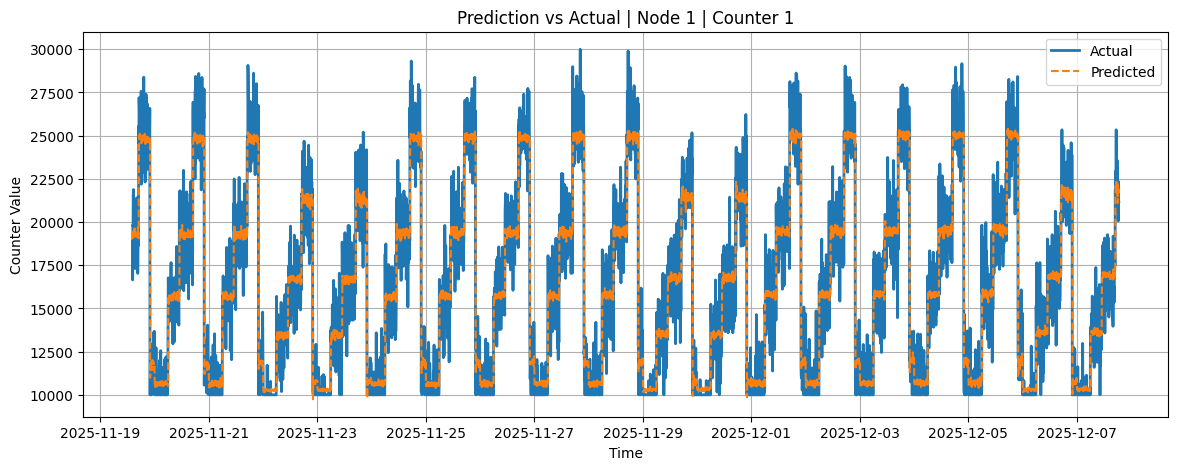

In [10]:
import matplotlib.pyplot as plt

def plot_single_node_counter(
    time_index_test,
    Y_test_inv, 
    Y_pred_inv,
    node_idx,            # index node (0..n_nodes-1)
    counter_idx,         # index counter trong target_counters (0..n_target_counters-1)
    target_counters,
    node_ids,
    title_prefix="Prediction vs Actual"
):
    """
    Vẽ biểu đồ đường cho 1 node và 1 counter.
    """
    actual = Y_test_inv[:, node_idx, counter_idx]
    pred   = Y_pred_inv[:, node_idx, counter_idx]

    counter_id = target_counters[counter_idx]
    node_id    = node_ids[node_idx]

    plt.figure(figsize=(14,5))
    plt.plot(time_index_test, actual, label="Actual", linewidth=2)
    plt.plot(time_index_test, pred, label="Predicted", linestyle="--")
    
    plt.title(f"{title_prefix} | Node {node_id} | Counter {counter_id}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend()
    plt.show()

time_index = df_pivot.index[n_past:]       # thời gian tương ứng với X,Y
# time_index_train = time_index[:len(X_train)]
# time_index_test  = time_index[len(X_train):]
time_index_test  = time_index[len(X_train):]

print(len(time_index))

plot_single_node_counter(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx=0,
    counter_idx=0,
    target_counters=target_counters,
    node_ids=node_ids
)

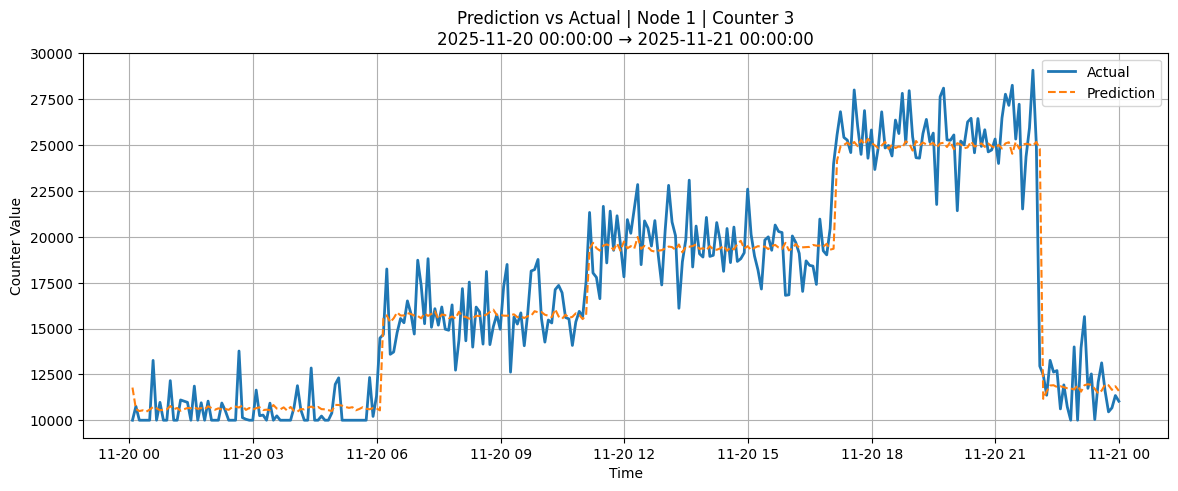

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_single_node_counter_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx,
    counter_idx,
    target_counters,
    node_ids,
    start_time,
    end_time,
    title_prefix="Prediction vs Actual"
):
    """
    Vẽ biểu đồ đường cho 1 node và 1 counter trong khoảng thời gian chỉ định.
    
    start_time, end_time: dạng string '2025-01-01 00:00:00' hoặc datetime
    """

    # Convert thời gian nếu cần
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    # --- Tìm index trong đoạn thời gian X -> Y ---
    mask = (time_index_test >= start_time) & (time_index_test <= end_time)

    if mask.sum() == 0:
        print("❌ Không có dữ liệu trong khoảng thời gian yêu cầu!")
        return

    t = time_index_test[mask]
    actual = Y_test_inv[mask, node_idx, counter_idx]
    pred   = Y_pred_inv[mask, node_idx, counter_idx]

    counter_id = target_counters[counter_idx]
    node_id = node_ids[node_idx]

    # --- Vẽ ---
    plt.figure(figsize=(14, 5))
    plt.plot(t, actual, label="Actual", linewidth=2)
    plt.plot(t, pred, label="Prediction", linestyle="--")

    plt.title(f"{title_prefix} | Node {node_id} | Counter {counter_id}\n{start_time} → {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_single_node_counter_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx=0,
    counter_idx=2,
    target_counters=target_counters,
    node_ids=node_ids,
    start_time="2025-11-20 00:00:00",
    end_time="2025-11-21 00:00:00"
)

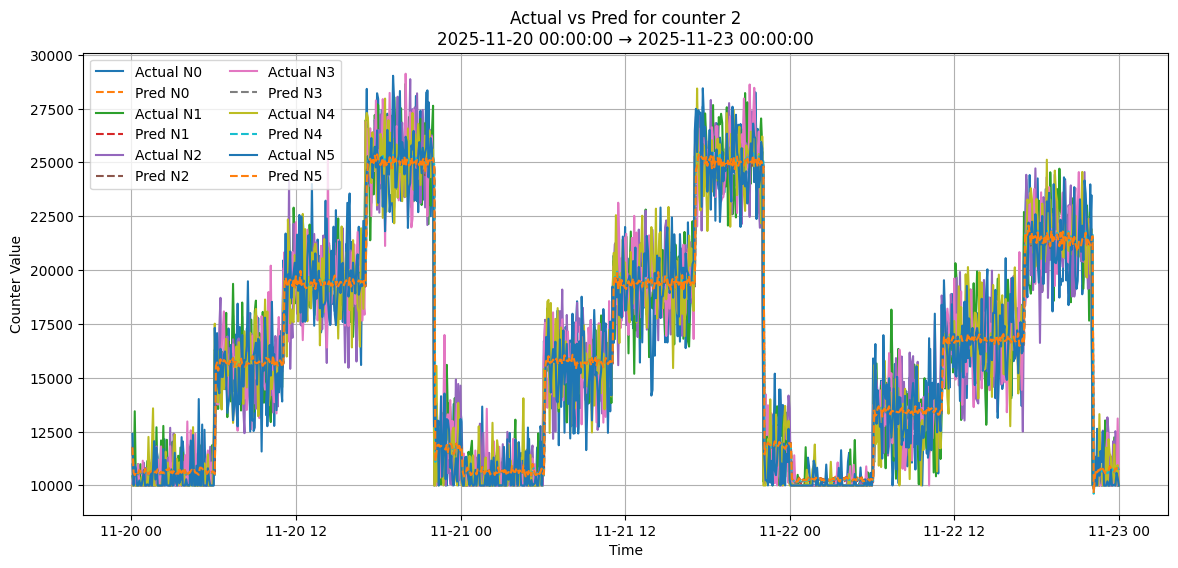

In [12]:
def plot_all_nodes_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    counter_idx,
    target_counters,
    node_ids,
    start_time,
    end_time
):
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    mask = (time_index_test >= start_time) & (time_index_test <= end_time)

    if mask.sum() == 0:
        print("❌ Không có dữ liệu trong khoảng thời gian yêu cầu!")
        return

    t = time_index_test[mask]
    n_nodes = Y_test_inv.shape[1]

    plt.figure(figsize=(14, 6))

    for i in range(n_nodes):
        plt.plot(t, Y_test_inv[mask, i, counter_idx], label=f"Actual N{i}")
        plt.plot(t, Y_pred_inv[mask, i, counter_idx], linestyle="--", label=f"Pred N{i}")

    counter_id = target_counters[counter_idx]

    plt.title(f"Actual vs Pred for counter {counter_id}\n{start_time} → {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()

plot_all_nodes_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    counter_idx=1,
    target_counters=target_counters,
    node_ids=node_ids,
    start_time="2025-11-20 00:00:00",
    end_time="2025-11-23 00:00:00"
)

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_per_node_counter(Y_test_inv, Y_pred_inv, target_counters, node_ids):
    """
    Tính MAE, RMSE cho từng (node_id, counter_id).
    """
    N_test, n_nodes, n_counters = Y_test_inv.shape

    results = []

    for i in range(n_nodes):
        for j in range(n_counters):
            actual = Y_test_inv[:, i, j]
            pred   = Y_pred_inv[:, i, j]

            mae  = mean_absolute_error(actual, pred)
            rmse = np.sqrt(mean_squared_error(actual, pred))

            results.append({
                "node_id": node_ids[i],
                "counter_id": target_counters[j],
                "MAE": mae,
                "RMSE": rmse
            })

    return results

results_node_counter = evaluate_per_node_counter(
    Y_test_inv, Y_pred_inv, target_counters, node_ids
)

import pandas as pd
df_eval = pd.DataFrame(results_node_counter)
df_eval


,node_id,counter_id,MAE,RMSE
0,1,1,1124.293537,1619.878378
1,1,2,1112.716066,1601.499077
2,1,3,1110.607346,1591.482590
3,2,1,1085.668273,1600.654051
4,2,2,1104.865091,1605.576929
5,2,3,1097.270056,1601.893272
6,3,1,1098.484267,1612.075093
7,3,2,1116.994275,1606.405187
8,3,3,1116.346511,1618.533601
9,4,1,1130.534724,1621.526129


In [15]:
def evaluate_per_counter(Y_test_inv, Y_pred_inv, target_counters):
    """
    MAE/RMSE cho từng counter_id (toàn bộ node).
    """
    N_test, n_nodes, n_counters = Y_test_inv.shape

    results = []

    for j in range(n_counters):
        actual = Y_test_inv[:, :, j].reshape(-1)   # flatten toàn bộ node
        pred   = Y_pred_inv[:, :, j].reshape(-1)

        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))

        results.append({
            "counter_id": target_counters[j],
            "MAE": mae,
            "RMSE": rmse
        })

    return results

df_counter = pd.DataFrame(evaluate_per_counter(Y_test_inv, Y_pred_inv, target_counters))
df_counter


,counter_id,MAE,RMSE
0,1,1109.495826,1609.874169
1,2,1111.005055,1604.937705
2,3,1111.900219,1608.627953


In [16]:
def evaluate_overall(Y_test_inv, Y_pred_inv):
    """
    MAE / RMSE toàn mô hình (mọi node + mọi counter).
    """
    actual = Y_test_inv.reshape(-1)
    pred   = Y_pred_inv.reshape(-1)

    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    return {"MAE": mae, "RMSE": rmse}

overall = evaluate_overall(Y_test_inv, Y_pred_inv)
overall


{'MAE': 1110.8003670061885, 'RMSE': 1607.814641800458}